# Demo #2: Multi-Query Decomposition (RAG-Fusion)

## Learning Objectives

In this demonstration, you will learn:

1. **Query Expansion**: How generating multiple query variations increases retrieval coverage
2. **RAG-Fusion**: The technique of retrieving from multiple query perspectives and fusing results
3. **Reciprocal Rank Fusion (RRF)**: An elegant algorithm for combining ranked lists without score normalization
4. **Recall vs. Precision**: Understanding the trade-off and how multi-query addresses it

## Theoretical Background

### The Problem: Single-Query Limitations

A single query, no matter how well-crafted, represents only one perspective on the information need. This creates two problems:

1. **Limited Recall**: Relevant documents that use different terminology may be missed
2. **Ambiguity**: The query may have multiple interpretations that should all be explored

### The Solution: Multi-Query Retrieval (RAG-Fusion)

RAG-Fusion addresses this by:

1. **Generating Multiple Query Variations**: Using an LLM to create 3-5 different ways to express the same information need
2. **Parallel Retrieval**: Executing each query variation independently against the vector store
3. **Result Fusion**: Combining all retrieved documents using Reciprocal Rank Fusion
4. **Re-ranking**: Producing a final, deduplicated ranking based on how often documents appear across different queries

### Reciprocal Rank Fusion (RRF)

RRF is a simple yet powerful algorithm for combining ranked lists:

```
RRF_score(document) = Σ [1 / (k + rank_in_query_i)]
```

Where:
- `k` is a constant (typically 60) to prevent division by zero and reduce the weight of higher ranks
- `rank_in_query_i` is the document's rank in the i-th query's results
- The sum is over all queries where the document appears

**Key Insight**: Documents that appear in the top results of multiple query variations get higher scores, indicating they are relevant from multiple perspectives.

**Key Citations**:
- Query Transformations - LangChain Blog (Reference 32)
- RAG techniques: From naive to advanced - Weights & Biases (Reference 20)

## 1. Environment Setup

In [1]:
# Core imports
import os
from pathlib import Path
from typing import List, Dict, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# LlamaIndex core components
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings,
    QueryBundle
)
from llama_index.core.schema import NodeWithScore
from llama_index.core.response_synthesizers import get_response_synthesizer

# Azure OpenAI components
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

# Utilities
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

print("✓ All imports successful")

✓ All imports successful


In [2]:
# Azure OpenAI Configuration
llm = AzureOpenAI(
    model="gpt-4",
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.7  # Higher temperature for diverse query generation
)

embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT", "text-embedding-ada-002"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview"
)

# Set global settings
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512
Settings.chunk_overlap = 50

print("✓ Azure OpenAI configured successfully")

✓ Azure OpenAI configured successfully


## 2. Data Preparation

In [3]:
# Load documents
data_path = Path("./data/ml_concepts")
documents = SimpleDirectoryReader(
    input_dir=str(data_path),
    required_exts=[".md"],
    recursive=False
).load_data()

# Use first 3-4 documents
documents = documents[:4]

print(f"✓ Loaded {len(documents)} documents:")
for i, doc in enumerate(documents, 1):
    filename = Path(doc.metadata.get('file_name', 'unknown')).name
    word_count = len(doc.text.split())
    print(f"  {i}. {filename} ({word_count} words)")

✓ Loaded 4 documents:
  1. gradient_boosting.md (233 words)
  2. kmeans_clustering.md (417 words)
  3. neural_networks.md (274 words)
  4. random_forests.md (368 words)


## 3. Build Vector Index

In [4]:
# Create vector store index
print("Building vector index...")
index = VectorStoreIndex.from_documents(
    documents,
    show_progress=True
)

# Create retriever with higher top-k for better recall
retriever = index.as_retriever(similarity_top_k=5)

print("✓ Index and retriever ready")

Building vector index...


Parsing nodes:   0%|          | 0/4 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/6 [00:00<?, ?it/s]

2025-10-16 14:34:18,828 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"


✓ Index and retriever ready


## 4. Multi-Query Generator

First, let's implement a function to generate multiple query variations using the LLM.

In [5]:
def generate_multiple_queries(original_query: str, num_queries: int = 3) -> List[str]:
    """
    Generate multiple variations of a query to increase retrieval coverage.
    
    Args:
        original_query: The user's original question
        num_queries: Number of query variations to generate
    
    Returns:
        List of query variations (including the original)
    """
    
    prompt = f"""You are an AI assistant helping to improve document retrieval.
    
Given the following question, generate {num_queries} alternative ways to ask the same question.
Each alternative should:
- Express the same information need from a different perspective
- Use different terminology or phrasing
- Be specific and clear

Original question: {original_query}

Generate exactly {num_queries} alternative questions, one per line, without numbering or bullets:"""
    
    response = llm.complete(prompt)
    
    # Parse the response to extract queries
    generated_queries = [
        q.strip() 
        for q in response.text.strip().split('\n') 
        if q.strip() and not q.strip().startswith(('1.', '2.', '3.', '-', '*'))
    ]
    
    # Clean up any remaining numbering
    generated_queries = [
        q.lstrip('123456789.-*) ').strip() 
        for q in generated_queries
    ][:num_queries]
    
    # Ensure we include the original query
    all_queries = [original_query] + generated_queries
    
    return all_queries

print("✓ Multi-query generator function defined")

✓ Multi-query generator function defined


## 5. Reciprocal Rank Fusion (RRF) Implementation

In [6]:
def reciprocal_rank_fusion(
    results_per_query: List[List[NodeWithScore]], 
    k: int = 60
) -> List[NodeWithScore]:
    """
    Implement Reciprocal Rank Fusion to combine results from multiple queries.
    
    Args:
        results_per_query: List of retrieval results, one list per query
        k: Constant for RRF formula (default 60)
    
    Returns:
        Fused and re-ranked list of nodes
    """
    
    # Dictionary to store RRF scores: node_id -> (node, score)
    rrf_scores = defaultdict(lambda: {'node': None, 'score': 0.0, 'appearances': 0})
    
    # Calculate RRF scores
    for query_results in results_per_query:
        for rank, node_with_score in enumerate(query_results, start=1):
            node_id = node_with_score.node.node_id
            
            # RRF formula: 1 / (k + rank)
            rrf_score = 1.0 / (k + rank)
            
            # Accumulate score
            rrf_scores[node_id]['score'] += rrf_score
            rrf_scores[node_id]['appearances'] += 1
            
            # Store the node (we only need one copy)
            if rrf_scores[node_id]['node'] is None:
                rrf_scores[node_id]['node'] = node_with_score.node
    
    # Convert to list and sort by RRF score
    fused_results = [
        NodeWithScore(node=data['node'], score=data['score'])
        for node_id, data in rrf_scores.items()
    ]
    
    fused_results.sort(key=lambda x: x.score, reverse=True)
    
    return fused_results

print("✓ RRF function defined")

✓ RRF function defined


## 6. RAG-Fusion Query Engine

Now let's create a complete RAG-Fusion pipeline that:
1. Generates multiple query variations
2. Retrieves documents for each variation
3. Applies RRF to fuse results
4. Generates a final answer

In [7]:
def rag_fusion_query(
    query: str, 
    retriever, 
    num_queries: int = 3,
    top_k_final: int = 5,
    verbose: bool = False
) -> Tuple[str, List[NodeWithScore], List[str]]:
    """
    Execute RAG-Fusion: multi-query retrieval with RRF fusion.
    
    Returns:
        (final_answer, fused_nodes, generated_queries)
    """
    
    # Step 1: Generate multiple query variations
    if verbose:
        print("\n" + "="*80)
        print("STEP 1: Generating Query Variations")
        print("="*80)
    
    queries = generate_multiple_queries(query, num_queries=num_queries)
    
    if verbose:
        print(f"\nOriginal Query: {queries[0]}")
        print(f"\nGenerated Variations:")
        for i, q in enumerate(queries[1:], 1):
            print(f"  {i}. {q}")
    
    # Step 2: Parallel retrieval for each query
    if verbose:
        print("\n" + "="*80)
        print("STEP 2: Parallel Retrieval")
        print("="*80)
    
    results_per_query = []
    for i, q in enumerate(queries):
        query_bundle = QueryBundle(query_str=q)
        results = retriever.retrieve(query_bundle)
        results_per_query.append(results)
        
        if verbose:
            print(f"\nQuery {i+1} retrieved {len(results)} nodes")
            print(f"  Top node: {Path(results[0].node.metadata.get('file_name', 'unknown')).stem}")
            print(f"  Score: {results[0].score:.4f}")
    
    # Step 3: Apply RRF fusion
    if verbose:
        print("\n" + "="*80)
        print("STEP 3: Reciprocal Rank Fusion")
        print("="*80)
    
    fused_results = reciprocal_rank_fusion(results_per_query)
    final_nodes = fused_results[:top_k_final]
    
    if verbose:
        print(f"\nFused to {len(final_nodes)} unique nodes:")
        for i, node in enumerate(final_nodes, 1):
            source = Path(node.node.metadata.get('file_name', 'unknown')).stem
            print(f"  {i}. {source} (RRF Score: {node.score:.4f})")
    
    # Step 4: Generate final answer
    if verbose:
        print("\n" + "="*80)
        print("STEP 4: Generate Final Answer")
        print("="*80)
    
    # Synthesize response using the fused context
    response_synthesizer = get_response_synthesizer(response_mode="compact")
    query_bundle = QueryBundle(query_str=query)
    response = response_synthesizer.synthesize(query_bundle, nodes=final_nodes)
    
    return response.response, final_nodes, queries

print("✓ RAG-Fusion query engine defined")

✓ RAG-Fusion query engine defined


## 7. Baseline vs RAG-Fusion Comparison

Let's compare single-query retrieval with RAG-Fusion.

In [8]:
# Test query
test_query = "How can ensemble methods improve prediction accuracy?"

print("\n" + "#" * 100)
print(f"# TEST QUERY: {test_query}")
print("#" * 100)


####################################################################################################
# TEST QUERY: How can ensemble methods improve prediction accuracy?
####################################################################################################


### 7.1 Baseline: Single Query Retrieval

In [9]:
print("\n" + "=" * 100)
print("BASELINE: Single Query Retrieval")
print("=" * 100)

# Single query retrieval
baseline_query_engine = index.as_query_engine(similarity_top_k=5)
baseline_response = baseline_query_engine.query(test_query)

print("\n📄 Retrieved Nodes:")
for i, node in enumerate(baseline_response.source_nodes, 1):
    source = Path(node.metadata.get('file_name', 'unknown')).stem
    print(f"  {i}. {source} (Score: {node.score:.4f})")
    print(f"     {node.text[:150]}...\n")

print("💬 Generated Answer:")
print(f"  {baseline_response.response}")
print()

2025-10-16 14:34:19,447 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



BASELINE: Single Query Retrieval


2025-10-16 14:34:20,878 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



📄 Retrieved Nodes:
  1. random_forests (Score: 0.8008)
     Choose the best split from these features
5. Grow the tree to maximum depth (no pruning)
6. Repeat steps 1-5 for N trees
7. Aggregate predictions by v...

  2. gradient_boosting (Score: 0.7881)
     # Gradient Boosting

Gradient Boosting is an ensemble machine learning technique that builds a strong predictive model by combining multiple weak lear...

  3. random_forests (Score: 0.7863)
     # Random Forests

Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode (classific...

  4. kmeans_clustering (Score: 0.7294)
     # K-Means Clustering

K-Means is an unsupervised learning algorithm that partitions data into K distinct, non-overlapping clusters based on feature si...

  5. neural_networks (Score: 0.7231)
     # Neural Networks

Neural Networks are computational models inspired by the human brain, consisting of interconnected nodes (neurons) organized in l

### 7.2 RAG-Fusion: Multi-Query with RRF

In [10]:
# RAG-Fusion with verbose output
fusion_answer, fusion_nodes, fusion_queries = rag_fusion_query(
    query=test_query,
    retriever=retriever,
    num_queries=3,
    top_k_final=5,
    verbose=True
)

print("\n💬 Final Answer:")
print(f"  {fusion_answer}")
print()


STEP 1: Generating Query Variations


2025-10-16 14:34:21,892 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:22,093 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



Original Query: How can ensemble methods improve prediction accuracy?

Generated Variations:
  1. In what ways do ensemble techniques enhance the precision of predictive models?
  2. What role do ensemble strategies play in boosting the accuracy of forecasting algorithms?
  3. How do ensemble approaches contribute to more accurate predictions in data analysis?

STEP 2: Parallel Retrieval


2025-10-16 14:34:22,191 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:22,286 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



Query 1 retrieved 5 nodes
  Top node: random_forests
  Score: 0.8009

Query 2 retrieved 5 nodes
  Top node: gradient_boosting
  Score: 0.7917

Query 3 retrieved 5 nodes
  Top node: random_forests
  Score: 0.7904


2025-10-16 14:34:22,376 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



Query 4 retrieved 5 nodes
  Top node: random_forests
  Score: 0.7947

STEP 3: Reciprocal Rank Fusion

Fused to 5 unique nodes:
  1. random_forests (RRF Score: 0.0653)
  2. gradient_boosting (RRF Score: 0.0648)
  3. random_forests (RRF Score: 0.0635)
  4. kmeans_clustering (RRF Score: 0.0625)
  5. neural_networks (RRF Score: 0.0615)

STEP 4: Generate Final Answer


2025-10-16 14:34:23,541 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"



💬 Final Answer:
  Ensemble methods improve prediction accuracy by combining multiple models to leverage their collective strengths. Techniques like Random Forests and Gradient Boosting use multiple decision trees to reduce errors and improve robustness. Random Forests enhance accuracy through averaging predictions, which reduces variance without increasing bias, while Gradient Boosting sequentially corrects errors by focusing on residuals, optimizing predictive performance. Both methods provide a strong, reliable model that is generally more accurate than individual models.



## 8. Detailed Analysis

Let's analyze the differences in retrieval quality.

In [11]:
import pandas as pd

def compare_retrieval_results(baseline_nodes, fusion_nodes, fusion_queries):
    """Create a detailed comparison of baseline vs fusion retrieval."""
    
    print("\n" + "="*100)
    print("RETRIEVAL COMPARISON ANALYSIS")
    print("="*100)
    
    # Extract sources
    baseline_sources = [Path(n.metadata.get('file_name', 'unknown')).stem for n in baseline_nodes]
    fusion_sources = [Path(n.node.metadata.get('file_name', 'unknown')).stem for n in fusion_nodes]
    
    # Calculate diversity metrics
    baseline_unique = len(set(baseline_sources))
    fusion_unique = len(set(fusion_sources))
    
    print(f"\n📊 Diversity Metrics:")
    print(f"  Baseline unique sources: {baseline_unique}/{len(baseline_sources)}")
    print(f"  Fusion unique sources:   {fusion_unique}/{len(fusion_sources)}")
    
    # Source overlap
    overlap = set(baseline_sources) & set(fusion_sources)
    fusion_only = set(fusion_sources) - set(baseline_sources)
    
    print(f"\n🔄 Source Overlap:")
    print(f"  Common sources: {len(overlap)} - {', '.join(overlap)}")
    if fusion_only:
        print(f"  ✨ New sources found by Fusion: {', '.join(fusion_only)}")
    
    # Create comparison table
    print(f"\n📋 Side-by-Side Ranking Comparison:")
    print("-" * 100)
    
    comparison_data = []
    max_len = max(len(baseline_sources), len(fusion_sources))
    
    for i in range(max_len):
        row = {'Rank': i + 1}
        
        if i < len(baseline_sources):
            row['Baseline Source'] = baseline_sources[i]
            row['Baseline Score'] = f"{baseline_nodes[i].score:.4f}"
        else:
            row['Baseline Source'] = '-'
            row['Baseline Score'] = '-'
        
        if i < len(fusion_sources):
            row['Fusion Source'] = fusion_sources[i]
            row['RRF Score'] = f"{fusion_nodes[i].score:.4f}"
        else:
            row['Fusion Source'] = '-'
            row['RRF Score'] = '-'
        
        comparison_data.append(row)
    
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Query variations summary
    print(f"\n🔍 Query Variations Used in Fusion:")
    print("-" * 100)
    for i, q in enumerate(fusion_queries, 1):
        print(f"  {i}. {q}")
    
    return {
        'baseline_diversity': baseline_unique / len(baseline_sources),
        'fusion_diversity': fusion_unique / len(fusion_sources),
        'new_sources_found': len(fusion_only)
    }

metrics = compare_retrieval_results(baseline_response.source_nodes, fusion_nodes, fusion_queries)


RETRIEVAL COMPARISON ANALYSIS

📊 Diversity Metrics:
  Baseline unique sources: 4/5
  Fusion unique sources:   4/5

🔄 Source Overlap:
  Common sources: 4 - gradient_boosting, random_forests, kmeans_clustering, neural_networks

📋 Side-by-Side Ranking Comparison:
----------------------------------------------------------------------------------------------------
 Rank   Baseline Source Baseline Score     Fusion Source RRF Score
    1    random_forests         0.8008    random_forests    0.0653
    2 gradient_boosting         0.7881 gradient_boosting    0.0648
    3    random_forests         0.7863    random_forests    0.0635
    4 kmeans_clustering         0.7294 kmeans_clustering    0.0625
    5   neural_networks         0.7231   neural_networks    0.0615

🔍 Query Variations Used in Fusion:
----------------------------------------------------------------------------------------------------
  1. How can ensemble methods improve prediction accuracy?
  2. In what ways do ensemble technique

## 9. Multiple Query Testing

Let's test with additional queries to see consistent improvements.

In [12]:
test_queries = [
    "What causes overfitting in machine learning models?",
    "How do neural networks learn patterns from data?",
    "Why is feature selection important for clustering?"
]

all_results = []

for query in test_queries:
    print(f"\n\n{'#'*100}")
    print(f"# Query: {query}")
    print(f"{'#'*100}")
    
    # Baseline
    baseline_resp = baseline_query_engine.query(query)
    baseline_sources = [Path(n.metadata.get('file_name', 'unknown')).stem 
                       for n in baseline_resp.source_nodes]
    baseline_diversity = len(set(baseline_sources)) / len(baseline_sources)
    
    # Fusion
    fusion_answer, fusion_nodes, fusion_queries = rag_fusion_query(
        query=query,
        retriever=retriever,
        num_queries=3,
        top_k_final=5,
        verbose=False
    )
    fusion_sources = [Path(n.node.metadata.get('file_name', 'unknown')).stem 
                     for n in fusion_nodes]
    fusion_diversity = len(set(fusion_sources)) / len(fusion_sources)
    
    # Calculate improvement
    new_sources = len(set(fusion_sources) - set(baseline_sources))
    
    print(f"\n📊 Results:")
    print(f"  Baseline diversity: {baseline_diversity:.2%}")
    print(f"  Fusion diversity:   {fusion_diversity:.2%}")
    print(f"  New sources found:  {new_sources}")
    
    all_results.append({
        'query': query[:50] + '...' if len(query) > 50 else query,
        'baseline_diversity': baseline_diversity,
        'fusion_diversity': fusion_diversity,
        'new_sources': new_sources
    })



####################################################################################################
# Query: What causes overfitting in machine learning models?
####################################################################################################


2025-10-16 14:34:23,853 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:25,216 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:25,932 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:26,018 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:26,104 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:26,195 - INFO - HTTP Request


📊 Results:
  Baseline diversity: 80.00%
  Fusion diversity:   80.00%
  New sources found:  0


####################################################################################################
# Query: How do neural networks learn patterns from data?
####################################################################################################


2025-10-16 14:34:30,117 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:30,713 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:30,818 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:30,910 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:31,003 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:31,101 - INFO - HTTP Request


📊 Results:
  Baseline diversity: 80.00%
  Fusion diversity:   80.00%
  New sources found:  0


####################################################################################################
# Query: Why is feature selection important for clustering?
####################################################################################################


2025-10-16 14:34:33,097 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:33,750 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:33,832 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:33,926 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:34,013 - INFO - HTTP Request: POST https://aoai-sweden-505.openai.azure.com/openai/deployments/text-embedding-ada-002/embeddings?api-version=2024-02-15-preview "HTTP/1.1 200 OK"
2025-10-16 14:34:34,102 - INFO - HTTP Request


📊 Results:
  Baseline diversity: 60.00%
  Fusion diversity:   60.00%
  New sources found:  0


## 10. Visualization

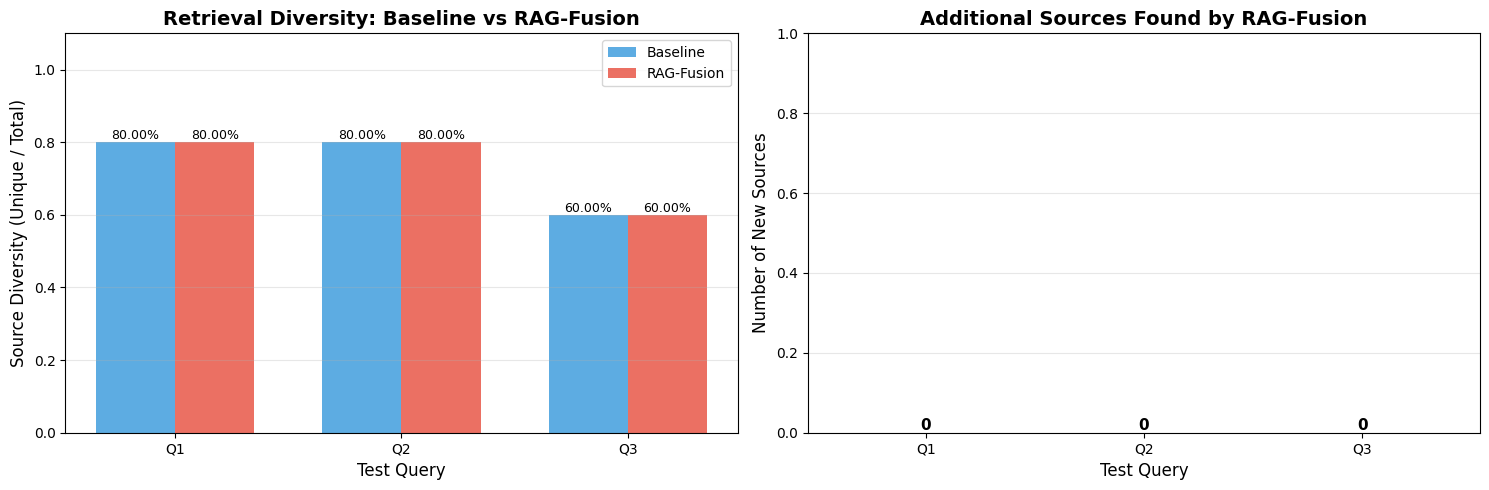


SUMMARY STATISTICS

Average Baseline Diversity:  73.33%
Average Fusion Diversity:    73.33%
Average Diversity Improvement: 0.00%

Total New Sources Discovered: 0
Average New Sources per Query: 0.0


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
queries_short = [r['query'] for r in all_results]
baseline_divs = [r['baseline_diversity'] for r in all_results]
fusion_divs = [r['fusion_diversity'] for r in all_results]
new_sources = [r['new_sources'] for r in all_results]

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Diversity comparison
x = np.arange(len(queries_short))
width = 0.35

bars1 = ax1.bar(x - width/2, baseline_divs, width, label='Baseline', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, fusion_divs, width, label='RAG-Fusion', alpha=0.8, color='#e74c3c')

ax1.set_xlabel('Test Query', fontsize=12)
ax1.set_ylabel('Source Diversity (Unique / Total)', fontsize=12)
ax1.set_title('Retrieval Diversity: Baseline vs RAG-Fusion', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Q1', 'Q2', 'Q3'])
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: New sources discovered
bars3 = ax2.bar(['Q1', 'Q2', 'Q3'], new_sources, alpha=0.8, color='#2ecc71')
ax2.set_xlabel('Test Query', fontsize=12)
ax2.set_ylabel('Number of New Sources', fontsize=12)
ax2.set_title('Additional Sources Found by RAG-Fusion', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(new_sources) + 1)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('rag_fusion_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
print(f"\nAverage Baseline Diversity:  {np.mean(baseline_divs):.2%}")
print(f"Average Fusion Diversity:    {np.mean(fusion_divs):.2%}")
print(f"Average Diversity Improvement: {(np.mean(fusion_divs) - np.mean(baseline_divs)):.2%}")
print(f"\nTotal New Sources Discovered: {sum(new_sources)}")
print(f"Average New Sources per Query: {np.mean(new_sources):.1f}")

## Key Takeaways

### What We Learned

1. **Single Queries Are Limiting**: A single query captures only one perspective, potentially missing relevant documents that use different terminology.

2. **Multi-Query Increases Coverage**: By generating multiple query variations, we cast a wider net and retrieve more diverse, comprehensive results.

3. **RRF is Elegant and Effective**: Reciprocal Rank Fusion provides a simple, parameter-light way to combine ranked lists without needing score normalization.

4. **Cross-Query Consensus Matters**: Documents that appear in results for multiple query variations are likely more relevant, as they satisfy the information need from multiple angles.

5. **Trade-off: Latency vs Quality**: RAG-Fusion requires multiple LLM calls (for query generation) and multiple retrievals, increasing latency but significantly improving recall.

### When to Use RAG-Fusion

✅ **Good for:**
- Complex, ambiguous queries
- Domain-specific terminology that may vary
- Cases where comprehensive coverage is critical
- Research and analysis tasks
- When you need diverse perspectives

❌ **Less effective for:**
- Simple, unambiguous lookups
- Real-time applications with strict latency requirements
- Very large scale systems where parallel retrieval is costly
- Cases where a single, precise answer is better than comprehensive coverage

### Implementation Considerations

- **Number of Query Variations**: 3-5 is typically optimal; more adds latency with diminishing returns
- **RRF Parameter k**: Default of 60 works well; larger k reduces the impact of ranking differences
- **Final Top-k**: Balance between context size and quality; 5-10 nodes is usually sufficient
- **Parallel Execution**: Implement async retrieval for better performance

### Next Steps

In the next demo, we'll explore **Hybrid Search**, combining dense vector search with sparse BM25 retrieval for even more robust retrieval that balances semantic understanding with exact keyword matching.